# Tachometer filter design using Intruction Trace Macrocell

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
CSV_TRACE_PATH = "../../SWV_export"
!ls {CSV_TRACE_PATH}

SWV_Data_Trace0.txt  SWV_Data_Trace1.txt  SWV_Data_Trace2.txt


In [20]:
def load_swv_series(filename,name, variable_count):
    df = pd.read_csv(filename, skiprows=variable_count+2,sep=";", names=["Access","Value","PC","Cycles","Time"])
    df.Time = df.Time.apply(lambda x: float(x.replace("s","")) if x != "?" else np.nan)
    df["Variable"] = name    
    df.drop(['PC'], axis=1,inplace=True)        
    df.dropna(axis=0,inplace=True)
    df.index = df.Time
    df.drop(['Access', 'Time'], axis=1,inplace=True)
    return df

In [21]:
df_tacho0 = load_swv_series(os.path.join(CSV_TRACE_PATH,"SWV_Data_Trace0.txt"),"Tacho0",3)
df_tacho0.head()

,Value,Cycles,Variable
Time,,,
141.479386,27425,13582021075,Tacho0
141.530925,52,13586968819,Tacho0
141.575399,44,13591238324,Tacho0
141.587210,12,13592372171,Tacho0
141.615869,29,13595123397,Tacho0


In [22]:
df_tacho1 = load_swv_series(os.path.join(CSV_TRACE_PATH,"SWV_Data_Trace1.txt"),"Tacho1",3)
df_tacho1.head()

,Value,Cycles,Variable
Time,,,
17.091969,58055,1640829037,Tacho1
17.091981,0,1640830166,Tacho1
17.157836,66,1647152234,Tacho1
17.172507,14,1648560636,Tacho1
17.208317,36,1651998451,Tacho1


In [23]:
df_throttle = load_swv_series(os.path.join(CSV_TRACE_PATH,"SWV_Data_Trace2.txt"),"Throttle",3)
df_throttle.head()

,Value,Cycles,Variable
Time,,,
4.567082,0.000000,438439892,Throttle
5.569858,0.032258,534706377,Throttle
6.572565,0.064516,630966246,Throttle
7.575255,0.096774,727224443,Throttle
8.577901,0.129032,823478472,Throttle


In [24]:
df = pd.concat([df_tacho0,df_tacho1,df_throttle]).sort_values("Time")
df

,Value,Cycles,Variable
Time,,,
4.567082,0.000000,438439892,Throttle
5.569858,0.032258,534706377,Throttle
6.572565,0.064516,630966246,Throttle
7.575255,0.096774,727224443,Throttle
8.577901,0.129032,823478472,Throttle
...,...,...,...
191.392166,111.000000,18373647912,Tacho0
191.398901,0.193548,18374294522,Throttle
191.455693,64.000000,18379746530,Tacho0


~~~c++
static uint32_t TachoLastTs[4] = { 0, 0, 0, 0 };	// Last timestamp in ms
static uint32_t TachoDT[4] = { 0, 0, 0, 0 }; 		// Deltatime with respect to last timestamp
static float AppliedThrottle[2] = { 0, 0 };			// Applied throttle

void HAL_GPIO_EXTI_Callback( uint16_t GPIO_Pin)
{
	uint32_t CurrTS = HAL_GetTick();
	switch(GPIO_Pin)
	{
		case TACHO1_Pin: { 	TachoDT[0] =  CurrTS - TachoLastTs[0]; TachoLastTs[0] = CurrTS; } break;
		case TACHO2_Pin: {  TachoDT[1] =  CurrTS - TachoLastTs[1]; TachoLastTs[1] = CurrTS; } break;
		case TACHO3_Pin: {  TachoDT[2] =  CurrTS - TachoLastTs[2]; TachoLastTs[2] = CurrTS; } break;
		case TACHO4_Pin: {  TachoDT[3] =  CurrTS - TachoLastTs[3]; TachoLastTs[3] = CurrTS; } break;
		default: { __NOP(); }
	};
	//HAL_GPIO_TogglePin(LD2_GPIO_Port, LD2_Pin);
}
~~~

/tmp/ipykernel_11715/4117423537.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Throttle"].index,
/tmp/ipykernel_11715/4117423537.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Throttle"].Value*100
/tmp/ipykernel_11715/4117423537.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].index,
/tmp/ipykernel_11715/4117423537.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].Value
/tmp/ipykernel_11715/4117423537.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho1"].index,
/tmp/ipykernel_11715/4117423537.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho1"].Value


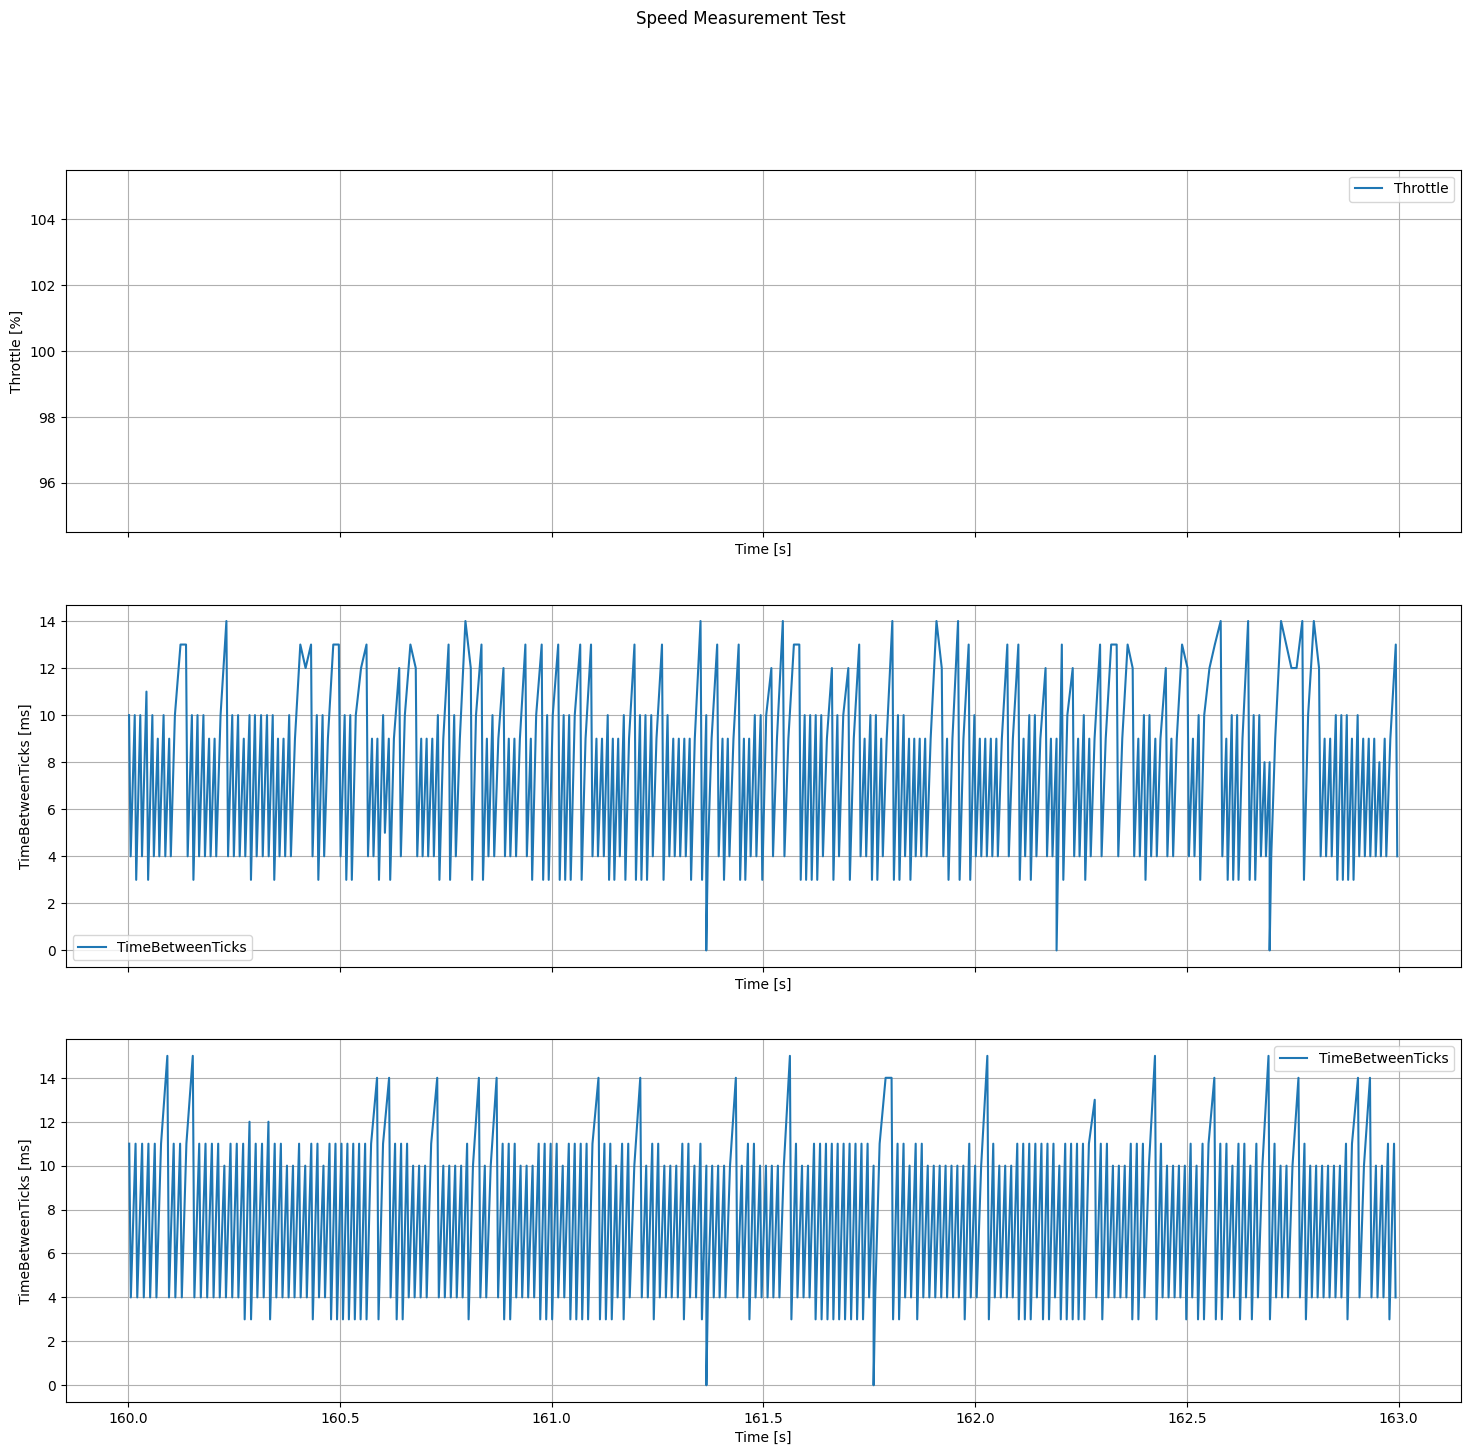

In [47]:
fig, axes = plt.subplots(3,1,figsize=(18,16),sharex=True)

region_filter = (df.index >= 160) & (df.index <= 163)

axes[0].plot(
    df[region_filter][df.Variable=="Throttle"].index,
    df[region_filter][df.Variable=="Throttle"].Value*100
)
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle"])

axes[1].plot(
    df[region_filter][df.Variable=="Tacho0"].index,
    df[region_filter][df.Variable=="Tacho0"].Value
)
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("TimeBetweenTicks [ms]")
axes[1].legend(["TimeBetweenTicks"])

axes[2].plot(
    df[region_filter][df.Variable=="Tacho1"].index,
    df[region_filter][df.Variable=="Tacho1"].Value
)
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("TimeBetweenTicks [ms]")
axes[2].legend(["TimeBetweenTicks"])

fig.suptitle("Speed Measurement Test");

/tmp/ipykernel_11715/2796250410.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].index,
/tmp/ipykernel_11715/2796250410.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].Value


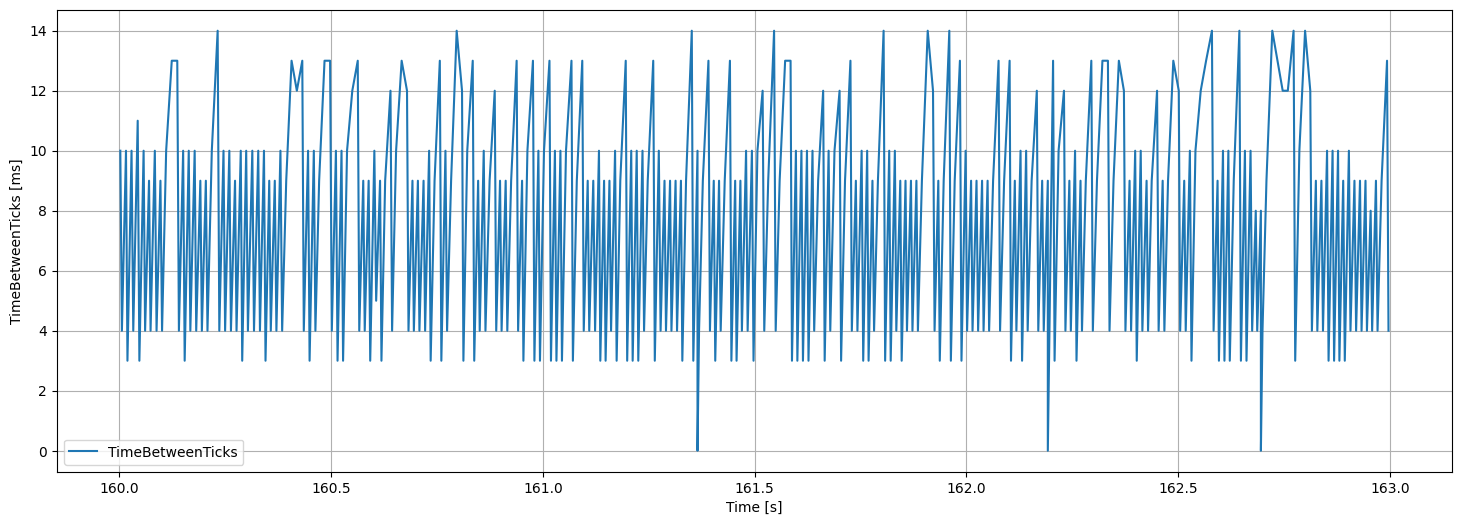

In [64]:
fig, axes = plt.subplots(1,1,figsize=(18,6),sharex=True)
region_filter = (df.index >= 160) & (df.index <= 163)



/tmp/ipykernel_11715/913496314.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].index,
/tmp/ipykernel_11715/913496314.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[region_filter][df.Variable=="Tacho0"].Value


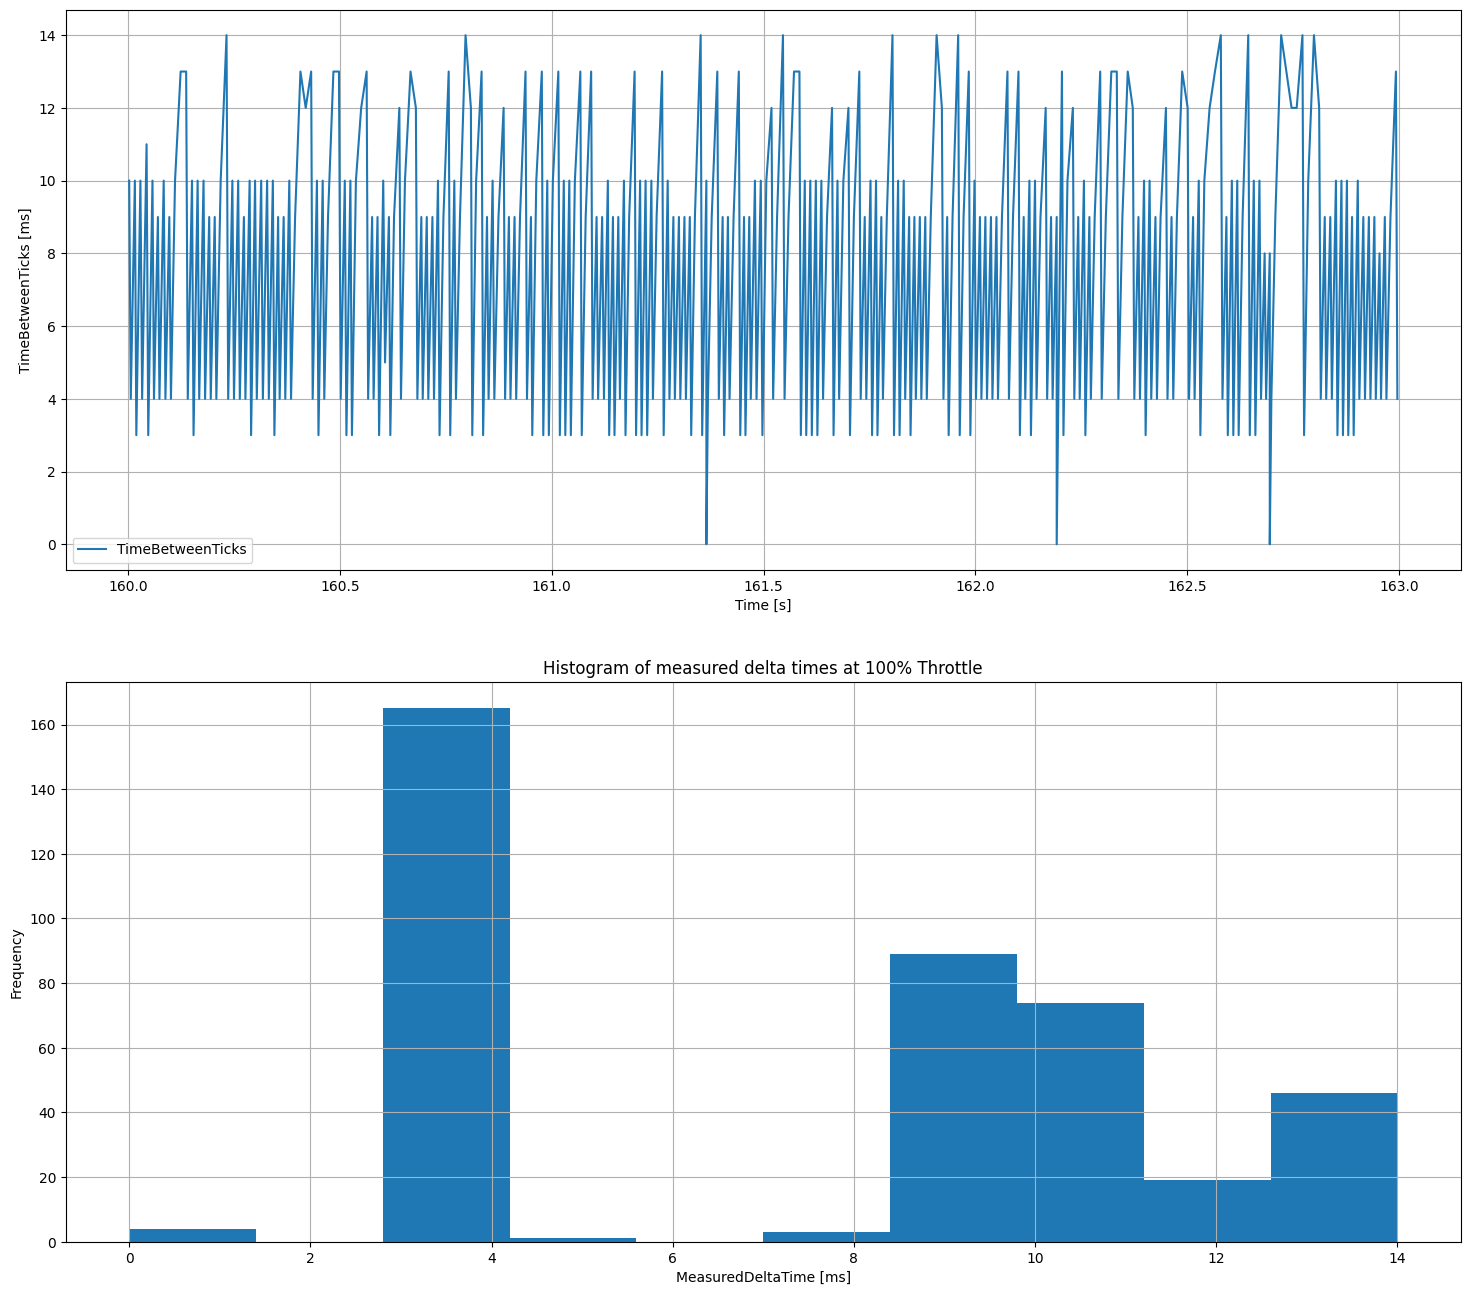

In [71]:
fig, axes = plt.subplots(2,1,figsize=(18,16))
region_filter = (df.index >= 160) & (df.index <= 163)

axes[0].plot(
    df[region_filter][df.Variable=="Tacho0"].index,
    df[region_filter][df.Variable=="Tacho0"].Value
)
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("TimeBetweenTicks [ms]")
axes[0].legend(["TimeBetweenTicks"])

axes[1].hist(df[region_filter & (df.Variable=="Tacho0")].Value)
axes[1].set_xlabel("MeasuredDeltaTime [ms]")
axes[1].set_ylabel("Frequency")
axes[1].set_title("Histogram of measured delta times at 100% Throttle")
axes[1].grid(which="Both")

In [ ]:
import numpy as np

y_subdivisions = 10
x_subdivisions = 20

x = np.arange(0,x_subdivisions*3)
y = np.zeros(shape=x.shape)

y[0]=0
y[1]=0
y[2]=0
for i in range(3,x_subdivisions,3):
    y[(i*3)] = y[(i*3)-1]
    y[(i*3)+1]=i/(x_subdivisions*3)
    y[(i*3)+2] = (y[(i*3)]+y[(i*3)+1])/2
    
fig,axes = plt.subplots(1,1,figsize=(22,4))
axes.plot(x,y);

In [ ]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
sos = signal.butter(0, 1, 'lowpass', fs=100, output='sos')
#filtered = signal.sosfilt(sos, df.AverageSpeed)
filtered = signal.medfilt(df.AverageSpeed, kernel_size=17)


fig, axes = plt.subplots(3,1,figsize=(18,12),sharex=True)
t = (df.OnBoardTime-df.OnBoardTime.iloc[0])/1000
axes[0].plot(t,df.Throttle1*100)
axes[0].set_title("Throttle")
axes[0].grid(which="Both")
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Throttle [%]")
axes[0].legend(["Throttle1"])

axes[1].plot(t,df.MeasuredSpeed1)
axes[1].plot(t,df.MeasuredSpeed2)
axes[1].plot(t,df.AverageSpeed)
axes[1].set_title("Measured speed(both wheels)")
axes[1].grid(which="Both")
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Measured speed [RPM]")
axes[1].legend(["Speed1","Speed2","Average"])

axes[2].plot(t,filtered)
axes[2].set_title("Measured speed(both wheels)")
axes[2].grid(which="Both")
axes[2].set_xlabel("Time [s]")
axes[2].set_ylabel("Measured speed [RPM]")
axes[2].legend(["Filtered"])
fig.suptitle("Speed Ramp Test - Left Side");